# Trajectory plots
This notebook reproduces Figure 5, plotting the selected vitals for the 2 selected trajectories.

## Loading data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
data_prefix = ''
datapath = '<REPLACE WITH OUTPUT PATH>'
figpath = './figs'
import sys; sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import pickle as pkl
import shelve
import numpy as np
import pandas as pd
from trajectoryInspection import mimic_utils as utils
from trajectoryInspection.mimic_config import colbin, collog, colnorm, feature_vars_map
from trajectoryInspection import mdp_utils as cf

# Avoid Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import logging as log
import sys
log.basicConfig(stream=sys.stdout, level=log.DEBUG)
log.getLogger('matplotlib').setLevel(log.WARNING)

from tqdm import tqdm_notebook as tqdm

# Max number of time steps
N_HORIZON=20

# Number of simulated trajectories / real trajectory
NCFSAMPS=5

# Since we've already learned a policy, no discounting here
DISCOUNT=1.

# Number of actions
nact = 25
# Number of states (clusters)
ncl = 750
# Indices
death_state_idx = ncl
lives_state_idx = ncl+1

In [3]:
# Read-only access to the data
data_dict = shelve.open("{}/{}data_dict.db".format(datapath, data_prefix), flag='r')

In [4]:
best_results = data_dict['best_results']

In [5]:
traj_train = data_dict['best_results']['traj_train']
traj_test = data_dict['traj_test']
final_obs_b_soft = data_dict['best_results']['obs_b_soft']
final_rl_pol_soft = data_dict['best_results']['rl_pol_soft']
final_rl_pol = data_dict['best_results']['rl_pol']

## Generating Model-Based Trajectories

The trajectory selected in `SurprisinglyPositiveOutcomes.ipynb` is reloaded here. The trajectory in `SurprisinglyAggressiveTreatments.ipynb` is regenerated here.

In [7]:
# Re-load our results from SurprisinglyPositiveOutcomes.ipynb
mb_dict = shelve.open("{}/mb_samples.db".format(datapath), flag='r')
test_samps_mb = mb_dict['test_samps_mb']

In [8]:
# Define the MDP we use for model-based rollouts
mdp_train_raw, mdp_train_raw_sampler, raw_obs_b = utils.create_mdp(
    data_dict['best_results']['traj_train'],
    remove_low_freq=False, 
    insta_death=False,
    soften=False,
    enforce_complete=False,
    nact=nact, ncl=ncl, 
    death_state_idx=death_state_idx, lives_state_idx=lives_state_idx,
    return_obs_b=True)

# Collect the test trajectories
test_samps = data_dict['test_samps']
test_idx_flat = data_dict['test_idx_flat']
test_idx = np.broadcast_to(test_idx_flat[:, np.newaxis], (test_idx_flat.shape[0], N_HORIZON))

In [9]:
test_samps_672_5 = []
test_idx_flat_672_5 = []
test_start_times_672_5 = []
for samp_idx in range(test_samps.shape[0]):
    for time_idx in range(test_samps.shape[1]):
        if test_samps[samp_idx,time_idx,2]==672 and test_samps[samp_idx,time_idx,1]==5:
            shifted_sample = np.zeros((test_samps.shape[1],test_samps.shape[2]))
            shifted_sample[:,0] = np.arange(20)
            shifted_sample[:test_samps.shape[1]-time_idx,1:] = test_samps[samp_idx,time_idx:,1:]
            shifted_sample[test_samps.shape[1]-time_idx:,1:-1] = -1
            test_samps_672_5.append(shifted_sample)
            icustayid = test_idx_flat[samp_idx]
            test_idx_flat_672_5.append(icustayid)
            test_start_times_672_5.append(time_idx)
            break
test_samps_672_5 = np.array(test_samps_672_5)
test_idx_flat_672_5 = np.array(test_idx_flat_672_5)
test_idx_672_5 = np.broadcast_to(test_idx_flat_672_5[:, np.newaxis], (test_idx_flat_672_5.shape[0], N_HORIZON))

In [10]:
# Generate model-based rollouts
np.random.seed(0)
test_samps_mb_672_5 = mdp_train_raw_sampler.cf_trajectory(
    test_samps_672_5,
    cf_policy=final_rl_pol,
    n_cf_samps=NCFSAMPS, use_tqdm=True,
    use_mb=True)  # This conditions on only the first state

100%|██████████| 40/40 [00:00<00:00, 65.42it/s]


## Plotting trajectories

In [ ]:
# These are the most relevant
#feature_vars = ['HR', 'SysBP', 'MeanBP', 'DiaBP', 'SpO2', 'WBC_count']# 'Arterial_lactate', 'SpO2']
feature_vars = ['HR', 'SysBP', 'DiaBP', 'WBC_count']# 'Arterial_lactate', 'SpO2']

# Get Data on the original scale, and unnormalize back to the proper scale
X = data_dict['X']
scaler = data_dict['scaler']
X_unnorm = utils.unnormalize_features(X, colbin, colnorm, collog, scaler)

# Get the values for various actinos
action_bins = data_dict['bin_info_dict']
vcl_min = action_bins['vcl']['medians'][0]
vcl_max = action_bins['vcl']['medians'][4]
iol_min = action_bins['iol']['medians'][0]
iol_max = action_bins['iol']['medians'][4]

# Get upper / lower bounds on features, for drawing the red lines
feature_min = np.min(X_unnorm.loc[:, feature_vars], axis=0)
#feature_lb = np.quantile(X_unnorm.loc[: , feature_vars], 0.05, axis=0)
feature_lb = np.array([60, 90, 60, 4.5])
#feature_ub = np.quantile(X_unnorm.loc[: , feature_vars], 0.95, axis=0)
feature_ub = np.array([100, 120, 80, 11])
feature_max = np.max(X_unnorm.loc[:, feature_vars], axis=0)

# Define some plotting related variables
action_vars = ['iol_median', 'vcl_median']
plotting_vars = feature_vars + action_vars
n_vars = len(plotting_vars)

# Set plotting parameters 
plt.rcParams.update({'font.size': 8})

plt_eps = 0.1
min_log_value = 10

outcome_symbol = {
        -1: {
            'marker': 'x',
            'color': 'r',
            'markersize': '8',
            'alpha': 1.,
            'name': '90-day Mortality',
            },
        0: {
            'marker': 'o',
            'color': 'k',
            'alpha': 0.2,
            'markersize': '4',
            'name': 'No Outcome'
            },
        1: {
            'marker': 'o',
            'color': 'g',
            'markersize': '8',
            'alpha': 1.,
            'name': '90-day Survival',
            },
        2: {
            'marker': 'o',
            'color': 'b',
            'markersize': '8',
            'alpha': 1.,
            'name': 'MB start'
            }
        }

from matplotlib.ticker import FormatStrFormatter

In [12]:
# Get outcomes and end-times for trajectories, required for plotting
def get_outcomes(traj, this_patient_id, this_cf_id=None):
    this_traj_set = traj.loc[(this_patient_id, )]
    if this_cf_id is not None:
        this_traj = this_traj_set.loc[this_traj_set.index.get_level_values('cf_index') == this_cf_id].reset_index()
    else:
        this_traj = this_traj_set.reset_index()

    # Counterfactual outcome is survival
    if (this_traj.loc[:, 'reward'] > 0).sum() > 0:
        this_traj_outcome = 1
        this_traj_endtime = this_traj[(this_traj.loc[:, 'reward'] > 0)]['bloc'].min()
        
    # Counterfactual outcome is death
    elif (this_traj.loc[:, 'reward'] < 0).sum() > 0:
        this_traj_outcome = -1
        this_traj_endtime = this_traj[(this_traj.loc[:, 'reward'] < 0)]['bloc'].min()
        
    # There is no counterfactual outcome... this is odd to think about, but a problem of the original model
    else:
        this_traj_outcome = 0
        this_traj_endtime = this_traj['bloc'].max()
        
    return this_traj_outcome, this_traj_endtime

In [14]:
feature_lookup = data_dict['feature_lookup']
action_lookup = data_dict['action_lookup']

# Actual Trajectories with all features
traj_test_full = data_dict['traj_test_full']
traj_test_full_reset_index = traj_test_full.reset_index()
traj_test_full_672_5 \
    = traj_test_full_reset_index.loc[traj_test_full_reset_index['icustayid'].isin(test_idx_flat_672_5)]
traj_test_full_672_5.set_index(['icustayid','bloc'],inplace=True)

# Model-based trajectories with appropriate indexing and only state / action / reward variables
traj_test_mb_672_5 = utils.recover_index(test_samps_mb_672_5, test_idx_672_5, 
                                   # This argument should be renamed, really asking 
                                   # "is there more than one trajectory per ICUstayID?"
                                   is_cf=True)

# Model-based trajectories with imputed features
traj_test_full_mb_672_5 = utils.traj_to_features(traj_test_mb_672_5, feature_lookup, action_lookup)

# Model-based trajectories with appropriate indexing and only state / action / reward variables
traj_test_mb = utils.recover_index(test_samps_mb, test_idx, 
                                   # This argument should be renamed, really asking 
                                   # "is there more than one trajectory per ICUstayID?"
                                   is_cf=True)

# Model-based trajectories with imputed features
traj_test_full_mb = utils.traj_to_features(traj_test_mb, feature_lookup, action_lookup)

In [16]:
def plot_two_patients(idx_1, idx_flat_1, start_times_1, traj_full_mb_1, traj_full_1, \
                      idx_2, idx_flat_2, start_times_2, traj_full_mb_2, traj_full_2, filename):
    patient_ids = [idx_flat_1[idx_1], idx_flat_2[idx_2]]
    patient_start_idxs = [start_times_1[idx_1], start_times_2[idx_2]]
    traj_fulls = [traj_full_1, traj_full_2]
    traj_full_mbs = [traj_full_mb_1, traj_full_mb_2]
    outcome_dict = dict()
    for j in range(len(patient_ids)):
        pid = patient_ids[j]
        outcome_dict[pid] = dict()
        factual_dict = {}
        factual_dict['outcome'], factual_dict['endtime'] = get_outcomes(traj_fulls[j], patient_ids[j])

        mb_dict = {}
        for i in range(NCFSAMPS):
            mb_dict[i] = {}
            mb_dict[i]['outcome'], mb_dict[i]['endtime'] = get_outcomes(traj_full_mbs[j], patient_ids[j], i)
            mb_dict[i]['endtime'] += patient_start_idxs[j]
        
        outcome_dict[pid]['factual'] = factual_dict
        outcome_dict[pid]['mb'] = mb_dict

        mb_endtimes = []
        for i in mb_dict.keys():
            mb_endtimes.append(mb_dict[i]['endtime'])

        outcome_dict[pid]['avg_mb_end'] = np.mean(mb_endtimes)
        outcome_dict[pid]['max_mb_end'] = np.max(mb_endtimes)
    
    these_vars = plotting_vars
    
    plt.rcParams.update({'font.size': 20})
    fig, axes = plt.subplots(nrows=len(these_vars), ncols=2, figsize=(16, 12), sharex='col', sharey='row')
    #fig.set_size_inches(8, 10)
    
    # Plot all the things
    for pid in range(len(patient_ids)):
        this_patient_id = patient_ids[pid]
        this_outcome_dict = outcome_dict[this_patient_id]
        this_patient_start_idx = patient_start_idxs[pid]
        traj_len = max(this_outcome_dict['factual']['endtime'] + 1,
                       this_outcome_dict['max_mb_end'] + 1)
        time_grid = np.arange(traj_len)
        time_grid_factual = np.arange(this_outcome_dict['factual']['endtime'] + 1)

        for i in range(len(these_vars)):
            this_col = these_vars[i]

            traj_full_reset_index = traj_fulls[pid].reset_index()
            df_factual = traj_test_full_reset_index.loc[traj_test_full_reset_index['icustayid']==this_patient_id]
            traj_full_mb_reset_index = traj_full_mbs[pid].reset_index()
            df_mb = traj_full_mb_reset_index.loc[traj_full_mb_reset_index['icustayid']==this_patient_id]

            #print(time_grid_factual)
            #print(df_factual[this_col])
            # These are imputed values
            #axes[i].plot(time_grid_factual, df_factual[this_col], 
            axes[i,pid].plot(time_grid_factual, df_factual[this_col],
                         color='k', label='Factual (K-means)')
            obs_end_time = this_outcome_dict['factual']['endtime']
            end_event = this_outcome_dict['factual']['outcome']

            # These are the true values
            if this_col not in ['iol_median', 'vcl_median']:
                #print(utils.unnormalize_features(X, colbin, colnorm, collog, scaler).loc[this_patient_id, this_col])
                axes[i,pid].plot(time_grid_factual, 
                         utils.unnormalize_features(X, colbin, colnorm, collog, scaler).loc[this_patient_id, this_col], 
                         color='k',
                         linestyle='--',
                         label='Factual')

            #print(obs_end_time)
            #print(df_factual[this_col])
            axes[i,pid].plot(obs_end_time, df_factual[this_col].values[-1], #[obs_end_time],
                         marker=outcome_symbol[end_event]['marker'],
                         color=outcome_symbol[end_event]['color'],
                         alpha=outcome_symbol[end_event]['alpha'])

            axes[i,pid].plot(this_patient_start_idx, df_factual[this_col].values[this_patient_start_idx], #[obs_end_time],
                         marker=outcome_symbol[2]['marker'],
                         color=outcome_symbol[2]['color'],
                         alpha=outcome_symbol[2]['alpha'])

            if these_vars[i] not in colbin + action_vars:
                axes[i,pid].hlines([feature_lb[i],
                                feature_ub[i]],
                               xmin=0, xmax=traj_len,
                               colors='r',
                               linestyles='dotted', label='90% range')        

            colors = ['orange', 'blue', 'pink', 'purple', 'green']
            for j in range(NCFSAMPS):
                this_mb_feature = df_mb.loc[
                    df_mb.cf_index == j, [this_col]]
                time_grid_mb = np.arange(this_patient_start_idx, this_outcome_dict['mb'][j]['endtime'] + 1)
                #print(time_grid_mb)
                #print(this_mb_feature.values)

                obs_end_time = this_outcome_dict['mb'][j]['endtime']
                end_event = this_outcome_dict['mb'][j]['outcome']

                # Select end-time outcome, to plot the markers using outcome_symbol
                if j == 0:
                    axes[i,pid].plot(time_grid_mb, this_mb_feature.values[:len(time_grid_mb)],
                                 color=colors[j], alpha=0.5, label='Model-Based Rollout')
                else:
                    axes[i,pid].plot(time_grid_mb, this_mb_feature.values[:len(time_grid_mb)],
                                 color=colors[j], alpha=0.5, label=None)

                axes[i,pid].plot(
                        obs_end_time,
                        this_mb_feature.values[len(time_grid_mb)-1], #this_mb_feature.loc[obs_end_time].values,
                        marker=outcome_symbol[end_event]['marker'],
                        color=outcome_symbol[end_event]['color'],
                        alpha=outcome_symbol[end_event]['alpha']
                        #label=outcome_symbol[end_event]['name']
                        ) 

            # Format the Y-axis according to the variable
            if pid == 0:
                ylabel = feature_vars_map[this_col]
                if 'Action' in ylabel:
                    ylabel = ylabel[len('Action: '):]
                axes[i,pid].set_ylabel(ylabel)

            if these_vars[i] == 'iol_median':
                axes[i,pid].set_ylim(iol_min, iol_max + 100)
            if these_vars[i] == 'vcl_median':
                axes[i,pid].set_ylim(vcl_min, vcl_max + 0.1)    

            axes[i,pid].set_xlim(-0.25, traj_len + 0.5)

            # Format the X-axis as integers
            axes[i,pid].xaxis.set_ticks(np.arange(0, traj_len + 1, 2))
            axes[i,pid].xaxis.set_major_formatter(FormatStrFormatter('%d'))

            #if i == 0:
            #    axes[i].legend()

        axes[-1,pid].set_xlabel('Time (4-hr block)')
        axes[0,pid].set_title('Patient ' + str(pid+1))
        plt.tight_layout()

    #plt.legend()
    #plt.savefig(filename)

    plt.show()

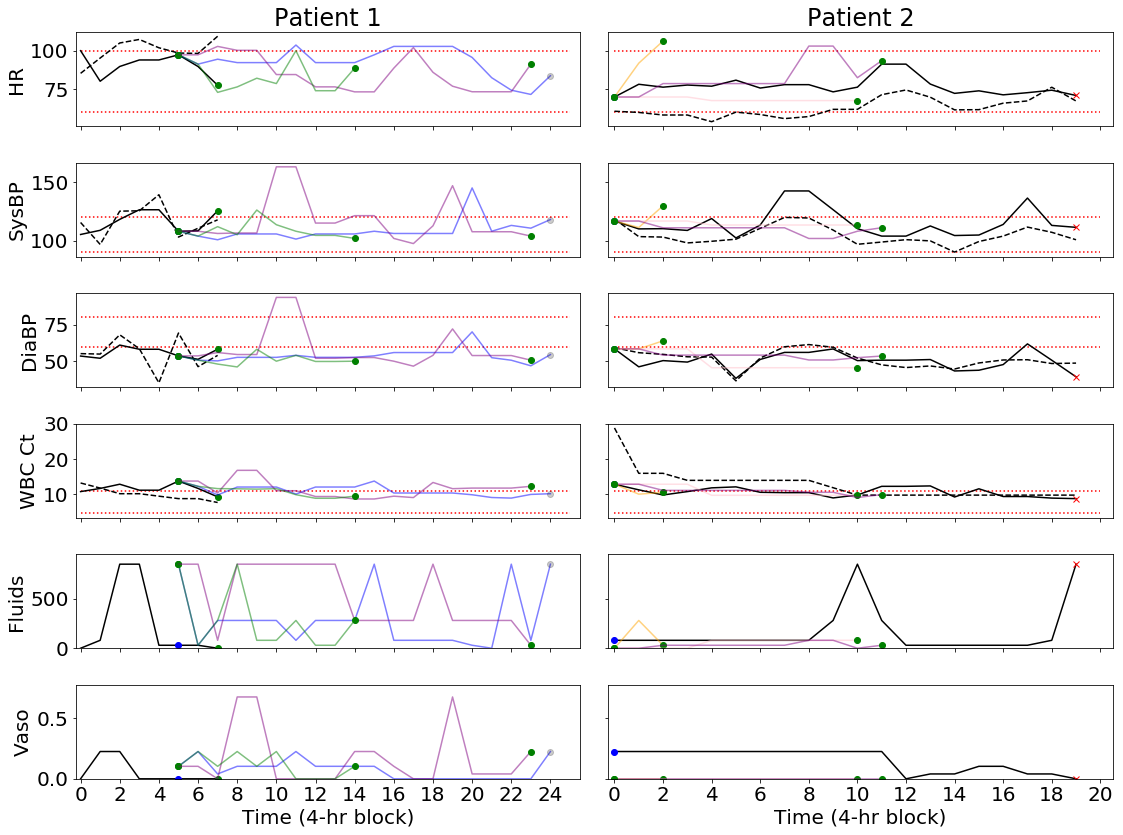

In [17]:
plot_two_patients(12, test_idx_flat_672_5, test_start_times_672_5, traj_test_full_mb_672_5, traj_test_full_672_5, \
                  1265, test_idx_flat, np.zeros(test_idx_flat.shape, dtype=np.int8).tolist(), \
                  traj_test_full_mb, traj_test_full, 'two_patients_final.pdf')